# **TL search task**
TL task image 2880장 사용

- Low similarity - singleton present : 720 images

- Low similarity - singleton absent : 720 images

- High similarity - singleton present : 720 images

- High similarity - singleton absent : 720 images

## **1. Model Definition**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D, Multiply, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model

class VVC(Model):
    def __init__(self, input_shape):
        super(VVC, self).__init__()
        self.base_model = VGG16(weights="imagenet", include_top=False, input_tensor=tf.keras.Input(shape=input_shape))
        self.base_model.trainable = False
        self.target_layer_output = self.base_model.get_layer('block5_conv3').output
        self.global_max_pool = GlobalAveragePooling2D(name="PFC_module")

    def call(self, inputs):
        target_output = Model(inputs=self.base_model.input, outputs=self.target_layer_output)(inputs)
        pooled_output = self.global_max_pool(target_output)
        return pooled_output


class SearchModel(Model):
    def __init__(self, input_shape, input_shape_vvc):
        super(SearchModel, self).__init__()
        self.base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
        self.base_model.trainable = False
        self.search_layer_output = self.base_model.get_layer('block5_conv3').output
        self.vvc_output_shape = input_shape_vvc

    def call(self, inputs):
        search_image, vvc_output = inputs
        search_output = Model(inputs=self.base_model.input, outputs=self.search_layer_output)(search_image)
        vvc_output_broadcast = tf.reshape(vvc_output, [-1, 1, 1, self.vvc_output_shape[-1]])
        combined_features = Multiply()([search_output, vvc_output_broadcast])
        #combined_features_resized = tf.image.resize(combined_features, [14, 14], method='bilinear')  # Shape: (1, 28, 28, 512)

        return combined_features

vvc_input_shape = (56, 56, 3)
input_shape_vvc = (512,)
search_input_shape = (448, 448, 3)

vvc_model = VVC(vvc_input_shape)
search_model = SearchModel(search_input_shape, input_shape_vvc)

# example data
vvc_image = tf.random.normal([1, 56, 56, 3])
search_image = tf.random.normal([1, 448, 448, 3])
vvc_output = vvc_model(vvc_image)

final_output = search_model([search_image, vvc_output])
print("Final output shape:", final_output.shape)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Final output shape: (1, 28, 28, 512)


VVC Model visualization saved as VVC_Model.png
Search Model visualization saved as Search_Model.png


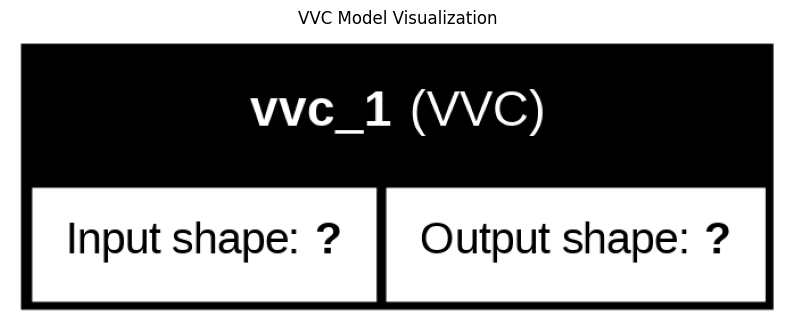

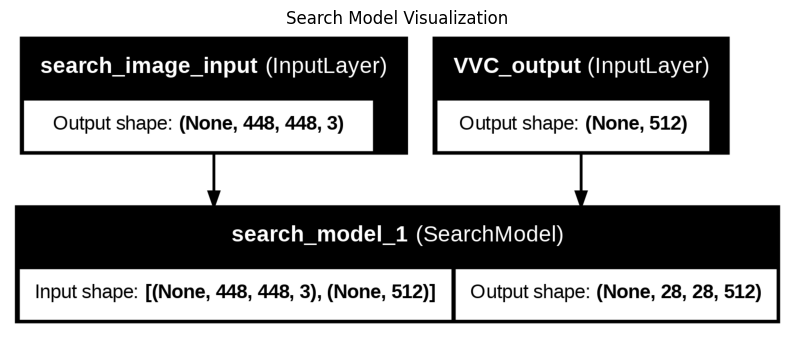

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import plot_model

# 더미 데이터 생성
vvc_dummy_data = tf.random.normal([1, 56, 56, 3])
search_dummy_data = tf.random.normal([1, 448, 448, 3])

# 더미 데이터로 모델 호출하여 구조 확정
vvc_output = vvc_model(vvc_dummy_data)
search_output = search_model([search_dummy_data, vvc_output])

# 모델 시각화
plot_model(vvc_model, to_file='VVC_Model.png', show_shapes=True, show_layer_names=True, rankdir='TB')
print("VVC Model visualization saved as VVC_Model.png")

# SearchModel의 더미 데이터 입력 및 시각화 준비
vvc_output_dummy = tf.keras.Input(shape=(512,), name='VVC_output')
search_image_dummy = tf.keras.Input(shape=(448, 448, 3), name='search_image_input')
dummy_model = Model(inputs=[search_image_dummy, vvc_output_dummy], outputs=search_model([search_image_dummy, vvc_output_dummy]))

plot_model(dummy_model, to_file='Search_Model.png', show_shapes=True, show_layer_names=True, rankdir='TB')
print("Search Model visualization saved as Search_Model.png")

# VVC 모델 시각화
vvc_image = Image.open('VVC_Model.png')
plt.figure(figsize=(10, 10))
plt.imshow(vvc_image)
plt.axis('off')  # 축을 표시하지 않음
plt.title('VVC Model Visualization')
plt.show()

# Search 모델 시각화
search_image = Image.open('Search_Model.png')
plt.figure(figsize=(10, 10))
plt.imshow(search_image)
plt.axis('off')
plt.title('Search Model Visualization')
plt.show()


## **2. Bottom-up attention map processing**
pretrained VGG16 model을 사용하여 search image를 통과시켰을 때 얻어지는 output을 bottom-up attention map으로 사용

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


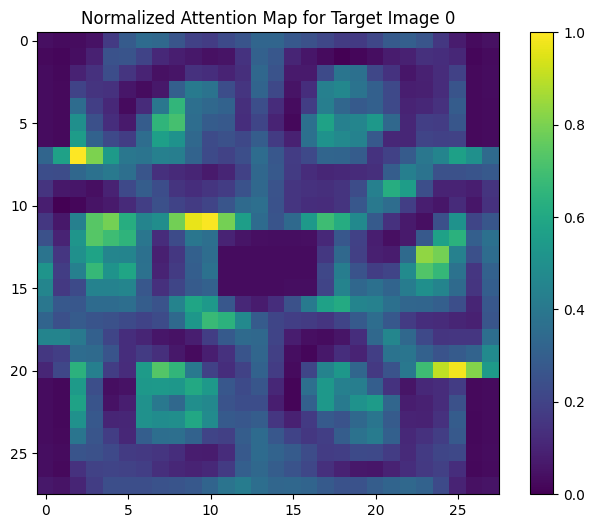

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import tensorflow as tf

def BTmodel(img_rows=448, img_cols=448):
    # Define the input tensor
    BTinput = Input(shape=(img_rows, img_cols, 3))

    # Load the base VGG16 model without the top layer
    base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=BTinput)

    # Make the base model non-trainable
    base_model.trainable = False

    # Get the output tensor of the 'block5_conv3' layer from the base model
    BTMap_output = base_model.get_layer('block5_conv3').output

    # Create a new model that takes the original input and outputs the tensor from 'block5_conv3'
    BTMap = Model(inputs=BTinput, outputs=BTMap_output)

    return BTMap

# Create the model with custom input size
bt_model = BTmodel(img_rows=448, img_cols=448)

# Preprocessing function modified for new input size
def preprocess_image(image_path, target_size=(448, 448)):
    img = tf.keras.utils.load_img(image_path, target_size=target_size)
    img = tf.keras.utils.img_to_array(img)
    img = tf.expand_dims(img, axis=0)
    return img

# Use the corrected model with new input size
search_img0 = preprocess_image('/content/drive/MyDrive/TL_Exp/pre/nooffset/img1.jpg')
attention_map0 = bt_model.predict(search_img0)

# Reduce, squeeze, normalize, and plot as before
attention_map0_reduced = tf.reduce_mean(attention_map0, axis=-1, keepdims=True)
attention_map0_2d = tf.squeeze(attention_map0_reduced, axis=[0, -1])
attention_map0_normalized = (attention_map0_2d - tf.reduce_min(attention_map0_2d)) / (tf.reduce_max(attention_map0_2d) - tf.reduce_min(attention_map0_2d))
attention_map0_normalized_np = attention_map0_normalized.numpy()

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(attention_map0_normalized_np, cmap='viridis')
plt.colorbar()
plt.title("Normalized Attention Map for Target Image 0")
plt.show()

In [ ]:
import os
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import numpy as np
import cv2


# Attention Map 생성
def generate_attention_map(search_img):
    attention_map = bt_model.predict(search_img)  # Output: (1, 14, 14, 512)
    attention_map_reduced = tf.reduce_mean(attention_map, axis=-1, keepdims=True)  # Output: (1, 14, 14, 1)
    attention_map_2d = tf.squeeze(attention_map_reduced, axis=[0, -1])  # Output: (14, 14)
    attention_map_normalized = (attention_map_2d - tf.reduce_min(attention_map_2d)) / (
        tf.reduce_max(attention_map_2d) - tf.reduce_min(attention_map_2d)
    )
    return attention_map_normalized

# Heatmap Overlay 생성
def generate_heatmap(search_img, attention_map_normalized, alpha=0.6):
    attention_map_resized = tf.image.resize(tf.expand_dims(attention_map_normalized, axis=-1), (224, 224)).numpy()
    attention_map_colored = cv2.applyColorMap((attention_map_resized * 255).astype(np.uint8), cv2.COLORMAP_HOT)
    heatmap = cv2.cvtColor(attention_map_colored, cv2.COLOR_BGR2RGB)
    return heatmap


# 경로 설정
search_dir = '/content/drive/MyDrive/TL_Exp/pre/offset'
output_dir = '/content/drive/MyDrive/TL_Exp/BtMap/offset'
os.makedirs(output_dir, exist_ok=True)

for i in range(1, 1441):
    #target_image_path = os.path.join(target_dir, f"{i}.jpg")
    search_image_path = os.path.join(search_dir, f"img{i}.jpg")
    output_image_path = os.path.join(output_dir, f"resized_attention_map_{i}.jpg")

    search_img = preprocess_image(search_image_path, target_size=(448, 448))

    # Attention Map 생성
    attention_map_normalized = generate_attention_map(search_img)

    # Heatmap 생성
    heatmap = generate_heatmap(search_img, attention_map_normalized)

    # Heatmap 저장
    plt.imsave(output_image_path, heatmap)
print("All heatmaps have been generated and saved.")



## **3. Top-down modultion 예제**
pretrained VGG16 model을 사용하여 target image를 통과시켰을 때 얻어지는 feature vector와 search image를 통과시켰을 때 얻어지는 output을 pixel-wise multification을 통해 top-down attention map으로 사용

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import cv2

# target image를 불러와 target size로 전처리
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = tf.expand_dims(img, axis=0)
    return img

target_img0 = preprocess_image('/content/drive/MyDrive/TL_Exp/target.jpg', target_size=(56, 56))
target_img1 = preprocess_image('/content/drive/MyDrive/TL_Exp/target.jpg', target_size=(56, 56))
target_img2 = preprocess_image('/content/drive/MyDrive/TL_Exp/target.jpg', target_size=(56, 56))

# VVC 모델에서 feature vector 추출
vvc_output0 = vvc_model.predict(target_img0)  # Output: (1, 512)
vvc_output1 = vvc_model.predict(target_img1)  # Output: (1, 512)
vvc_output2 = vvc_model.predict(target_img2)  # Output: (1, 512)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


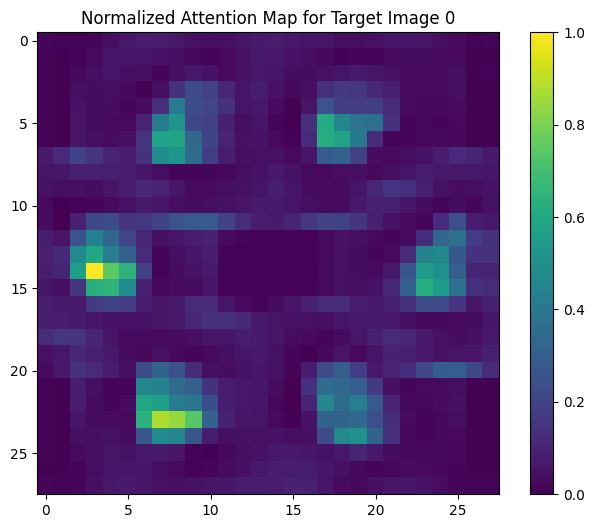

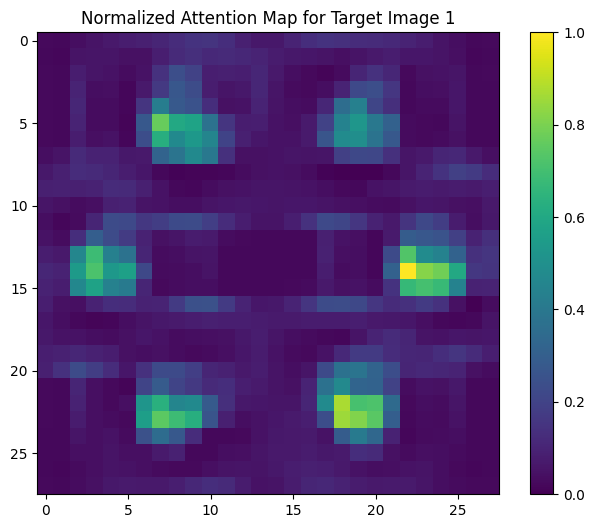

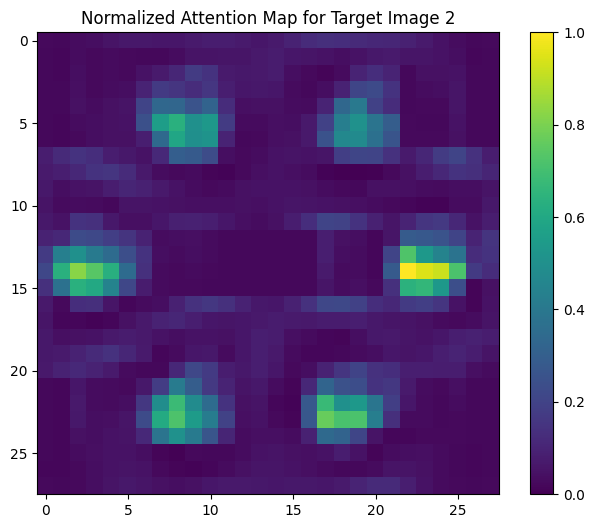

In [ ]:
# Reshape VVC outputs: VVC 모델의 2D output(1x512)을 4D(1x1x1x512)로 변환
vvc_output0_reshaped = tf.expand_dims(tf.expand_dims(vvc_output0, axis=1), axis=1) # Shape: (1x1x1x512)
vvc_output1_reshaped = tf.expand_dims(tf.expand_dims(vvc_output1, axis=1), axis=1) # Shape: (1x1x1x512)
vvc_output2_reshaped = tf.expand_dims(tf.expand_dims(vvc_output2, axis=1), axis=1) # Shape: (1x1x1x512)

# search image를 불러와 target size (224x224)로 전처리
search_img0 = preprocess_image('/content/drive/MyDrive/TL_Exp/pre/nooffset/img1.jpg', target_size=(448, 448))
search_img1 = preprocess_image('/content/drive/MyDrive/TL_Exp/pre/offset/img1.jpg', target_size=(448, 448))
search_img2 = preprocess_image('/content/drive/MyDrive/TL_Exp/pre/offset/img721.jpg', target_size=(448, 448))

# Search 모델에서 top-down modulation을 통해 attention map 추출
attention_map0 = search_model.predict([search_img0, vvc_output0_reshaped])  # Output: (1, 14, 14, 512)
attention_map1 = search_model.predict([search_img1, vvc_output1_reshaped])  # Output: (1, 14, 14, 512)
attention_map2 = search_model.predict([search_img2, vvc_output2_reshaped])  # Output: (1, 14, 14, 512)

## attention map 시각화
# 1. 1x14x14x512 형태인 attention map을 512개의 channel을 평균내어 1x14x14x1 형태의 attention map 생성
attention_map0_reduced = tf.reduce_mean(attention_map0, axis=-1, keepdims=True)  # Output: (1, 14, 14, 1)
attention_map1_reduced = tf.reduce_mean(attention_map1, axis=-1, keepdims=True)  # Output: (1, 14, 14, 1)
attention_map2_reduced = tf.reduce_mean(attention_map2, axis=-1, keepdims=True)  # Output: (1, 14, 14, 1)

# 2. 시각화를 위해 2D로 변환
attention_map0_2d = tf.squeeze(attention_map0_reduced, axis=[0, -1])  # Output: (14, 14)
attention_map1_2d = tf.squeeze(attention_map1_reduced, axis=[0, -1])  # Output: (14, 14)
attention_map2_2d = tf.squeeze(attention_map2_reduced, axis=[0, -1])  # Output: (14, 14)

# 3. 활성화 값을 시각화를 위해 0~1의 값으로 normalization
attention_map0_normalized = (attention_map0_2d - tf.reduce_min(attention_map0_2d)) / (tf.reduce_max(attention_map0_2d) - tf.reduce_min(attention_map0_2d))
attention_map1_normalized = (attention_map1_2d - tf.reduce_min(attention_map1_2d)) / (tf.reduce_max(attention_map1_2d) - tf.reduce_min(attention_map1_2d))
attention_map2_normalized = (attention_map2_2d - tf.reduce_min(attention_map2_2d)) / (tf.reduce_max(attention_map2_2d) - tf.reduce_min(attention_map2_2d))

# 4. matrix를 numpy로 변환
attention_map0_normalized_np = attention_map0_normalized.numpy()
attention_map1_normalized_np = attention_map1_normalized.numpy()
attention_map2_normalized_np = attention_map2_normalized.numpy()

# Plot normalized attention map for Target Image 0
plt.figure(figsize=(8, 6))
plt.imshow(attention_map0_normalized_np, cmap='viridis')
plt.colorbar()
plt.title("Normalized Attention Map for Target Image 0")
plt.show()

# Plot normalized attention map for Target Image 1
plt.figure(figsize=(8, 6))
plt.imshow(attention_map1_normalized_np, cmap='viridis')
plt.colorbar()
plt.title("Normalized Attention Map for Target Image 1")
plt.show()


# Plot normalized attention map for Target Image 1
plt.figure(figsize=(8, 6))
plt.imshow(attention_map2_normalized_np, cmap='viridis')
plt.colorbar()
plt.title("Normalized Attention Map for Target Image 2")
plt.show()



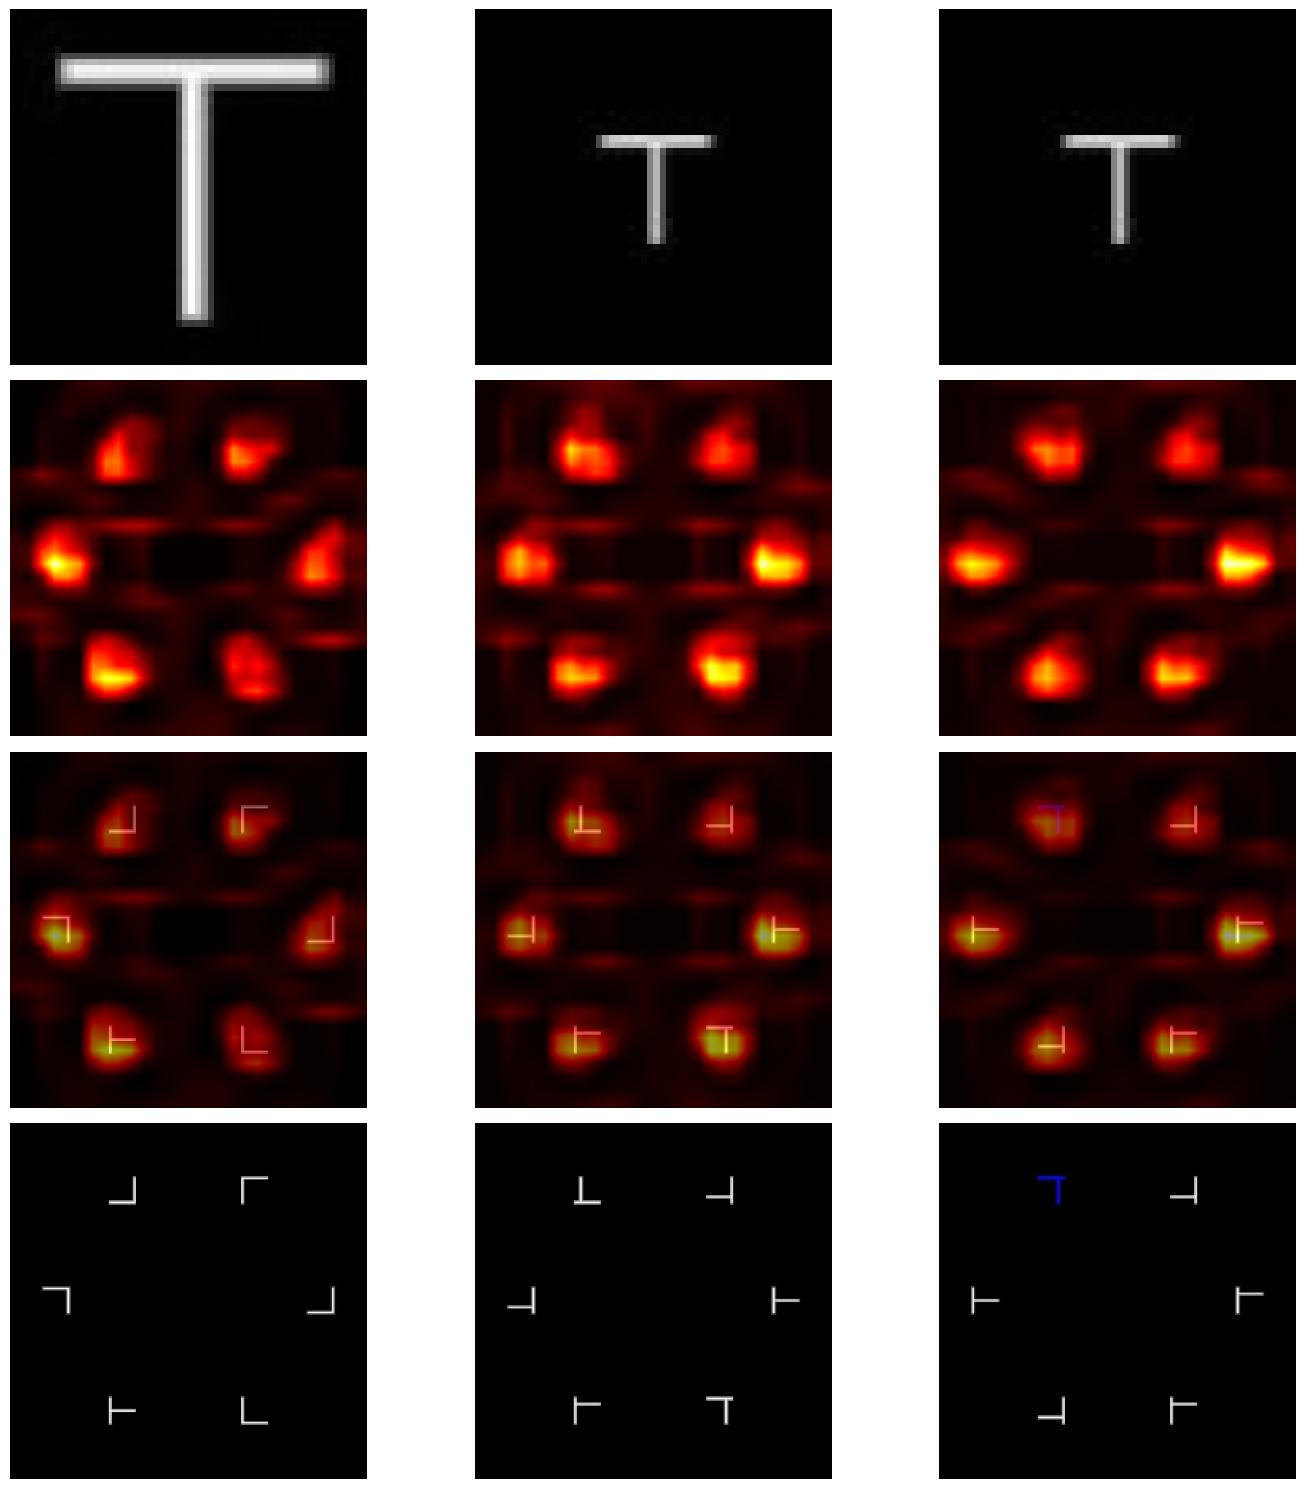

In [ ]:
## Overlay Attention Map 시각화

# 1. Attention map을 시각화 및 처리하기 위해 channel dimension 추가
attention_map0_normalized = tf.expand_dims(attention_map0_normalized, axis=-1)  # Shape: (28, 28, 1)
attention_map1_normalized = tf.expand_dims(attention_map1_normalized, axis=-1)  # Shape: (28, 28, 1)
attention_map2_normalized = tf.expand_dims(attention_map2_normalized, axis=-1)  # Shape: (28, 28, 1)


# 2. 224x224 크기의 search image와 attention map 크기를 맞춤
attention_map0_resized = tf.image.resize(attention_map0_normalized, (448, 448)).numpy()
attention_map1_resized = tf.image.resize(attention_map1_normalized, (448, 448)).numpy()
attention_map2_resized = tf.image.resize(attention_map2_normalized, (448, 448)).numpy()

# 3. Viridis color map을 적용하여 heatmap 생성
attention_map0_colored = cv2.applyColorMap((attention_map0_resized * 255).astype(np.uint8), cv2.COLORMAP_HOT)
attention_map1_colored = cv2.applyColorMap((attention_map1_resized * 255).astype(np.uint8), cv2.COLORMAP_HOT)
attention_map2_colored = cv2.applyColorMap((attention_map2_resized * 255).astype(np.uint8), cv2.COLORMAP_HOT)

# 4. heatmap을 RGB 형식으로 변환
heatmap0 = cv2.cvtColor(attention_map0_colored, cv2.COLOR_BGR2RGB)
heatmap1 = cv2.cvtColor(attention_map1_colored, cv2.COLOR_BGR2RGB)
heatmap2 = cv2.cvtColor(attention_map2_colored, cv2.COLOR_BGR2RGB)

# 5. Search 이미지를 NumPy 배열로 변환하고 [0, 1] 범위로 정규화
search_img0_np = search_img0[0].numpy() / 255.0
search_img1_np = search_img1[0].numpy() / 255.0
search_img2_np = search_img2[0].numpy() / 255.0

# 6. Attention map을 [0, 1] 범위로 정규화
attention_map0_colored = heatmap0.astype(np.float32) / 255.0
attention_map1_colored = heatmap1.astype(np.float32) / 255.0
attention_map2_colored = heatmap2.astype(np.float32) / 255.0

# 7. Heatmap과 원본 이미지를 투명도 0.6으로 중첩
overlay_alpha = 0.6  # Transparency factor
overlay0 = cv2.addWeighted(search_img0_np, 1 - overlay_alpha, attention_map0_colored, overlay_alpha, 0)
overlay1 = cv2.addWeighted(search_img1_np, 1 - overlay_alpha, attention_map1_colored, overlay_alpha, 0)
overlay2 = cv2.addWeighted(search_img2_np, 1 - overlay_alpha, attention_map2_colored, overlay_alpha, 0)


# Target image를 시각화하기 위한 형태로 변환
target_img0_np = target_img0[0].numpy() / 255.0  # Normalize to [0, 1]
target_img1_np = target_img1[0].numpy() / 255.0
target_img2_np = target_img2[0].numpy() / 255.0

# Plot Target Images, Overlays, and Search Images
plt.figure(figsize=(15, 15))

# Target Image 0
plt.subplot(4, 3, 1)
plt.imshow(target_img0_np)
plt.axis('off')

# Target Image 1
plt.subplot(4, 3, 2)
plt.imshow(target_img1_np)
plt.axis('off')

# Target Image 2
plt.subplot(4, 3, 3)
plt.imshow(target_img2_np)
plt.axis('off')

# Attention Map 0 (before overlay)
plt.subplot(4, 3, 4)
plt.imshow(heatmap0, cmap='hot')
plt.axis('off')

# Attention Map 1 (before overlay)
plt.subplot(4, 3, 5)
plt.imshow(heatmap1, cmap='hot')
plt.axis('off')

# Attention Map 2 (before overlay)
plt.subplot(4, 3, 6)
plt.imshow(heatmap2, cmap='hot')
plt.axis('off')

# Overlay 0
plt.subplot(4, 3, 7)
plt.imshow(overlay0)
plt.axis('off')

# Overlay 1
plt.subplot(4, 3, 8)
plt.imshow(overlay1)
plt.axis('off')

# Overlay 2
plt.subplot(4, 3, 9)
plt.imshow(overlay2)
plt.axis('off')

# Search Image 0
plt.subplot(4, 3, 10)
plt.imshow(search_img0_np)
plt.axis('off')

# Search Image 1
plt.subplot(4, 3, 11)
plt.imshow(search_img1_np)
plt.axis('off')

# Search Image 2
plt.subplot(4, 3, 12)
plt.imshow(search_img2_np)
plt.axis('off')

plt.tight_layout()
plt.show()


## **4. Top-down attention map processing**

In [ ]:
import os
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 이미지 전처리
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = tf.expand_dims(img, axis=0)
    return img

# Attention Map 생성
def generate_attention_map(search_img, vvc_output, search_model):
    vvc_output_reshaped = tf.expand_dims(tf.expand_dims(vvc_output, axis=1), axis=1)  # Shape: (1, 1, 1, 512)
    attention_map = search_model.predict([search_img, vvc_output_reshaped])  # Output: (1, 28, 28, 512)
    attention_map_reduced = tf.reduce_mean(attention_map, axis=-1, keepdims=True)  # Output: (1, 28, 28, 1)
    attention_map_2d = tf.squeeze(attention_map_reduced, axis=[0, -1])  # Output: (28, 28)
    attention_map_normalized = (attention_map_2d - tf.reduce_min(attention_map_2d)) / (
        tf.reduce_max(attention_map_2d) - tf.reduce_min(attention_map_2d)
    )
    return attention_map_normalized

# Heatmap Overlay 생성
def generate_heatmap(search_img, attention_map_normalized, alpha=0.6):
    attention_map_resized = tf.image.resize(tf.expand_dims(attention_map_normalized, axis=-1), (224, 224)).numpy()
    attention_map_colored = cv2.applyColorMap((attention_map_resized * 255).astype(np.uint8), cv2.COLORMAP_HOT)
    heatmap = cv2.cvtColor(attention_map_colored, cv2.COLOR_BGR2RGB)
    return heatmap

In [ ]:
## 1. Exp1 dataset processing

# 경로 설정
target_image_path  = '/content/drive/MyDrive/TL_Exp/target.jpg'
search_dir = '/content/drive/MyDrive/TL_Exp/pre/offset'
output_dir = '/content/drive/MyDrive/TL_Exp/TdMap/offset'
os.makedirs(output_dir, exist_ok=True)

target_img = preprocess_image(target_image_path, target_size=(56, 56))
vvc_output = vvc_model.predict(target_img)

for i in range(1, 1441):
    search_image_path = os.path.join(search_dir, f"img{i}.jpg")
    output_image_path = os.path.join(output_dir, f"resized_attention_map_{i}.jpg")

    # 이미지 전처리
    search_img = preprocess_image(search_image_path, target_size=(448, 448))

    # Attention Map 생성
    attention_map_normalized = generate_attention_map(search_img, vvc_output, search_model)

    # Heatmap 생성
    heatmap = generate_heatmap(search_img, attention_map_normalized)

    # Heatmap 저장
    plt.imsave(output_image_path, heatmap)

    #print(f"Saved heatmap for image {i} at {output_image_path}")

print("All heatmaps have been generated and saved.")

## **5. Fixation processing for the dataset**
Winner-Takes-All mechanism을 사용하여 eye movement fixation을 예측

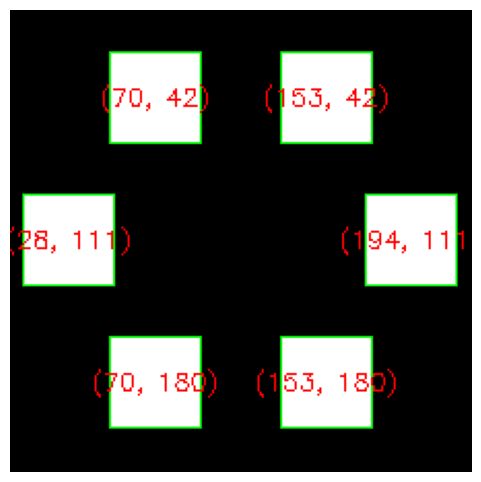

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


# 224x224 이미지 생성 (배경은 검은색)
image = np.zeros((224, 224, 3), dtype=np.uint8)
image2 = np.zeros((224, 224, 3), dtype=np.uint8)

# 이미지 중심 좌표 및 크기
center_positions = [(153, 180), (70, 180), (28, 111), (194, 111), (153, 42), (70, 42)]


image_size = 44  # 스케일 다운된 이미지 크기

# 각 중심 위치에 테두리를 그리고 이미지 추가 (여기서는 간단한 흰색 사각형으로 대체)
for center in center_positions:
    top_left = (center[0] - image_size // 2, center[1] - image_size // 2)
    bottom_right = (center[0] + image_size // 2, center[1] + image_size // 2)
    cv2.rectangle(image, top_left, bottom_right, (255, 255, 255), -1)  # 흰색 사각형으로 이미지 영역 표시
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 1)  # 테두리 그리기 (녹색)

    # 중심 좌표 표시
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = f"({center[0]}, {center[1]})"
    text_size = cv2.getTextSize(text, font, 0.4, 1)[0]
    text_x = center[0] - text_size[0] // 2
    text_y = center[1] + text_size[1] // 2
    cv2.putText(image, text, (text_x, text_y), font, 0.4, (255, 0, 0), 1)

# 이미지 출력
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.show()



In [ ]:
# TL task image
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import imageio
from PIL import Image
import io

# Location 정의 (데이터에서의 tloc 좌표)
locations = {
    0: (111, 194),
    1: (42, 153),
    2: (42, 70),
    3: (111, 28),
    4: (180, 70),
    5: (180, 153)
}

# Region Of Interest (ROI) 정의
def define_ROI(fixed_locations, region_size=22):
    return [
        (
            max(0, y - region_size), min(224, y + region_size),
            max(0, x - region_size), min(224, x + region_size)
        )
        for y, x in fixed_locations
    ]


# 가중치 업데이트 함수
def update_weights(t, max_fixations=6):
    alpha = [1,1,1,1,1,1]
    beta = [1,1,1,1,1,1]

    return alpha[t], beta[t]

def is_fixation_in_region(fixation, center, region_radius=22):
    """
    특정 Fixation이 주어진 중심 영역(center) 안에 있는지 확인.
    """
    fy, fx = fixation
    cy, cx = center
    return abs(fy - cy) <= region_radius and abs(fx - cx) <= region_radius


# WTA_with_IOR 함수
def WTA_with_IOR(saliency_map, TD_map, search_regions, target_region_index, output_dir, original_image, max_fixations=6):
    fixation_points = [(112, 112)]
    excluded_regions = set()
    images = []

    for t in range(max_fixations):
        alpha, beta = update_weights(t)
        combined_map = alpha * saliency_map + beta * TD_map
        #print(alpha, beta)

        max_value, max_location, max_region_index = -np.inf, None, None
        for i, region in enumerate(search_regions):
            if i in excluded_regions:
                continue
            region_values = combined_map[region[0]:region[1], region[2]:region[3]]
            local_max_idx = np.unravel_index(np.argmax(region_values), region_values.shape)
            global_max_idx = (region[0] + local_max_idx[0], region[2] + local_max_idx[1])

            if combined_map[global_max_idx] > max_value:
                max_value, max_location, max_region_index = combined_map[global_max_idx], global_max_idx, i

        fixation_points.append(max_location)
        print(max_value)
        excluded_regions.add(max_region_index)

        # 원본 이미지에 Attention Map 오버레이
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(original_image, cmap='gray', interpolation='none')
        ax.imshow(combined_map, cmap='jet', alpha=0.6, interpolation='none')  # 알파 값으로 투명도 조절
        for idx, (y, x) in enumerate(fixation_points):
            ax.scatter(x, y, c='red', s=100 if idx == t + 1 else 50)
            ax.text(x, y, str(idx), color="white", fontsize=8)
        plt.axis('off')

        # 이미지 저장
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)  # 여백 제거 옵션 추가
        plt.close()
        buf.seek(0)
        image = Image.open(buf)
        images.append(np.array(image))

        if max_region_index == target_region_index:
            break

    imageio.mimsave(f'{output_dir}/fixation_sequence_{image_idx}.gif', images, fps=1, loop=0)

    return fixation_points, max_region_index == target_region_index



# 데이터 준비
file_path = '/content/drive/MyDrive/TL_Exp/offset.xlsx'
data = pd.read_excel(file_path)

output_dir = '/content/drive/MyDrive/TL_Exp/SearchOutput/offset'  # Output 디렉터리 설정
os.makedirs(output_dir, exist_ok=True)  # 디렉터리 생성
results = [] # 결과 저장 리스트

# Fixed Locations 및 ROI 정의
fixed_locations = list(locations.values())
search_regions = define_ROI(fixed_locations, region_size=22)

for image_idx in range(1, 1441):
    trial = data.loc[image_idx - 1, 'trialidx']
    target_loc_id = data.loc[image_idx - 1, 'tloc']
    salient_loc_id = data.loc[image_idx - 1, 'sloc']
    target_region_index = target_loc_id

    # saliency map & top-down attention map & original attention map 로드
    saliency_map_path = f'/content/drive/MyDrive/TL_Exp/BtMap/offset/resized_attention_map_{image_idx}.jpg'
    TD_map_path = f'/content/drive/MyDrive/TL_Exp/TdMap/offset/resized_attention_map_{image_idx}.jpg'
    original_image_path = f'/content/drive/MyDrive/TL_Exp/pre/offset/img{image_idx}.jpg'
    saliency_map_image = cv2.imread(saliency_map_path, cv2.IMREAD_GRAYSCALE)
    TD_map_image = cv2.imread(TD_map_path, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.resize(original_image, (224, 224))  # 이미지 리사이즈
    saliency_map = saliency_map_image / 255.0  # Normalize to [0, 1]
    TD_map = TD_map_image / 255.0  # Normalize to [0, 1]
    original_image = original_image / 255.0  # Normalize to [0, 1]


    # 탐색 시행
    fixation_points, found = WTA_with_IOR(
        saliency_map,
        TD_map,
        search_regions,
        target_region_index,
        output_dir,
        original_image,
        max_fixations=6
    )

    # sloc 검사
    if salient_loc_id == -1:
        sloc_fixation_index = -1  # salient distractor 없음
    else:
        sloc_center = locations[salient_loc_id]
        sloc_fixation_index = -2  # 초기값: 존재하지만 찍히지 않음
        for idx, fixation in enumerate(fixation_points):
            if is_fixation_in_region(fixation, sloc_center):
                sloc_fixation_index = idx
                break

    # 결과 저장
    results.append({
        "image_idx": image_idx,
        "trialidx": trial,
        "target_location": locations[target_region_index],
        "fixations_count": len(fixation_points) - 1,
        "found": found,
        "sloc_fixation_index": sloc_fixation_index
    })

    #print(f"Processed Image {image_idx}: Target {'found' if found else 'not found'} after {len(fixation_points) - 1} fixations.")


# CSV 파일 저장
results_df = pd.DataFrame(results)
results_csv_path = "/content/drive/MyDrive/TL_Exp/SearchOutput/offset_result.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")


In [ ]:
# sTL task image
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import imageio
from PIL import Image
import io

# Location 정의 (데이터에서의 tloc 좌표)
locations = {
    0: (111, 184),
    1: (53, 155),
    2: (52, 82),
    3: (111, 38),
    4: (169, 67),
    5: (170, 155)
}

# Region Of Interest (ROI) 정의
def define_ROI(fixed_locations, region_size=20):
    return [
        (
            max(0, y - region_size), min(224, y + region_size),
            max(0, x - region_size), min(224, x + region_size)
        )
        for y, x in fixed_locations
    ]


# 가중치 업데이트 함수
def update_weights(t, max_fixations=6):
    alpha = [1,1,1,1,1,1]
    beta = [1,1,1,1,1,1]
    return alpha[t], beta[t]


def is_fixation_in_region(fixation, center, region_radius=20):
    """
    특정 Fixation이 주어진 중심 영역(center) 안에 있는지 확인.
    """
    fy, fx = fixation
    cy, cx = center
    return abs(fy - cy) <= region_radius and abs(fx - cx) <= region_radius


# WTA_with_IOR 함수
def WTA_with_IOR(saliency_map, TD_map, search_regions, target_region_index, output_dir, original_image, max_fixations=6):
    fixation_points = [(112, 112)]
    excluded_regions = set()
    images = []

    for t in range(max_fixations):
        alpha, beta = update_weights(t)
        combined_map = alpha * saliency_map + beta * TD_map

        max_value, max_location, max_region_index = -np.inf, None, None
        for i, region in enumerate(search_regions):
            if i in excluded_regions:
                continue
            region_values = combined_map[region[0]:region[1], region[2]:region[3]]
            local_max_idx = np.unravel_index(np.argmax(region_values), region_values.shape)
            global_max_idx = (region[0] + local_max_idx[0], region[2] + local_max_idx[1])

            if combined_map[global_max_idx] > max_value:
                max_value, max_location, max_region_index = combined_map[global_max_idx], global_max_idx, i

        fixation_points.append(max_location)
        excluded_regions.add(max_region_index)

        # 원본 이미지에 Attention Map 오버레이
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(original_image, cmap='gray', interpolation='none')
        ax.imshow(combined_map, cmap='jet', alpha=0.6, interpolation='none')  # 알파 값으로 투명도 조절
        for idx, (y, x) in enumerate(fixation_points):
            ax.scatter(x, y, c='red', s=100 if idx == t + 1 else 50)
            ax.text(x, y, str(idx), color="white", fontsize=8)
        plt.axis('off')

        # 이미지 저장
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)  # 여백 제거 옵션 추가
        plt.close()
        buf.seek(0)
        image = Image.open(buf)
        images.append(np.array(image))

        if max_region_index == target_region_index:
            break

    imageio.mimsave(f'{output_dir}/fixation_sequence_{image_idx}.gif', images, fps=1, loop=0)

    return fixation_points, max_region_index == target_region_index



# 데이터 준비
file_path = '/content/drive/MyDrive/TL_Exp/sTL.xlsx'
data = pd.read_excel(file_path)

output_dir = '/content/drive/MyDrive/TL_Exp/SearchOutput/sTL'  # Output 디렉터리 설정
os.makedirs(output_dir, exist_ok=True)  # 디렉터리 생성
results = [] # 결과 저장 리스트

# Fixed Locations 및 ROI 정의
fixed_locations = list(locations.values())
search_regions = define_ROI(fixed_locations, region_size=20)

for image_idx in range(1, 1441):
    trial = data.loc[image_idx - 1, 'trialidx']
    target_loc_id = data.loc[image_idx - 1, 'tloc']
    salient_loc_id = data.loc[image_idx - 1, 'sloc']
    target_region_index = target_loc_id

    # saliency map & top-down attention map & original attention map 로드
    saliency_map_path = f'/content/drive/MyDrive/TL_Exp/BtMap/sTL/resized_attention_map_{image_idx}.jpg'
    TD_map_path = f'/content/drive/MyDrive/TL_Exp/TdMap/sTL/resized_attention_map_{image_idx}.jpg'
    original_image_path = f'/content/drive/MyDrive/TL_Exp/pre/sTL/img{image_idx}.jpg'
    saliency_map_image = cv2.imread(saliency_map_path, cv2.IMREAD_GRAYSCALE)
    TD_map_image = cv2.imread(TD_map_path, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.resize(original_image, (224, 224))  # 이미지 리사이즈
    saliency_map = saliency_map_image / 255.0  # Normalize to [0, 1]
    TD_map = TD_map_image / 255.0  # Normalize to [0, 1]
    original_image = original_image / 255.0  # Normalize to [0, 1]


    # 탐색 시행
    fixation_points, found = WTA_with_IOR(
        saliency_map,
        TD_map,
        search_regions,
        target_region_index,
        output_dir,
        original_image,
        max_fixations=6
    )

    # sloc 검사
    if salient_loc_id == -1:
        sloc_fixation_index = -1  # salient distractor 없음
    else:
        sloc_center = locations[salient_loc_id]
        sloc_fixation_index = -2  # 초기값: 존재하지만 찍히지 않음
        for idx, fixation in enumerate(fixation_points):
            if is_fixation_in_region(fixation, sloc_center):
                sloc_fixation_index = idx
                break

    # 결과 저장
    results.append({
        "image_idx": image_idx,
        "trialidx": trial,
        "target_location": locations[target_region_index],
        "fixations_count": len(fixation_points) - 1,
        "found": found,
        "sloc_fixation_index": sloc_fixation_index
    })

    #print(f"Processed Image {image_idx}: Target {'found' if found else 'not found'} after {len(fixation_points) - 1} fixations.")


# CSV 파일 저장
results_df = pd.DataFrame(results)
results_csv_path = "/content/drive/MyDrive/TL_Exp/SearchOutput/sTL_result.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")


## **6. Result visualization**

                             Condition  Mean Fixations  Std Fixations
0    Low Similarity - Singleton Absent        1.744444       0.754198
1   Low Similarity - Singleton Present        2.258333       1.082128
2   High Similarity - Singleton Absent        4.422222       1.231056
3  High Similarity - Singleton Present        4.293056       1.159807
Two-way ANOVA Results:
                                 sum_sq      df            F        PR(>F)
C(similarity)               3997.378125     1.0  3475.626312  0.000000e+00
C(singleton)                  26.642014     1.0    23.164605  1.563875e-06
C(similarity):C(singleton)    74.433681     1.0    64.718336  1.250652e-15
Residual                    3307.737500  2876.0          NaN           NaN

Low similarity: Distractor Absent vs. Present T-test Results:
Statistic: -10.454031462396078, P-value: 1.3214466541279587e-24

High similarity: Distractor Absent vs. Present T-test Results:
Statistic: 2.0491987735983077, P-value: 0.04062444822581118


<ipython-input-2-785649c7ab98>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df['Condition'], rotation=45, ha="right")


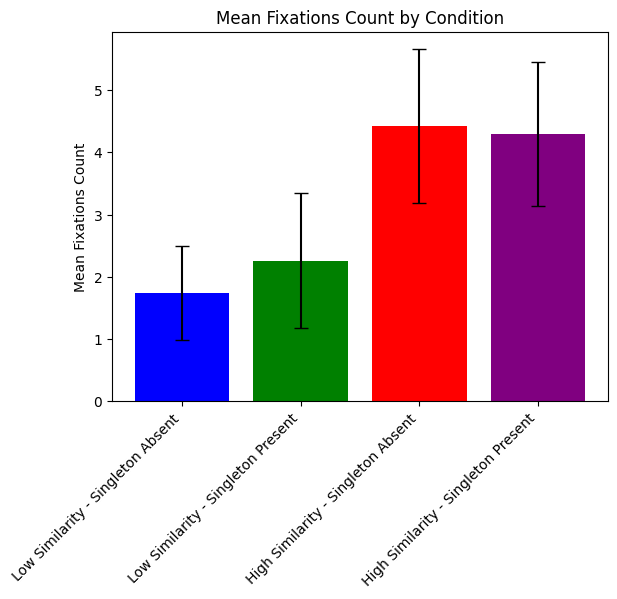

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.graphics.api as smg
from scipy.stats import ttest_ind


# 데이터 로드
file_path = "/content/drive/MyDrive/TL_Exp/SearchOutput/final_result.csv"
data = pd.read_csv(file_path)

# 조건별 그룹핑
# Search Type: 0 = Parallel, 1 = Serial
# Distractor: 0 = Absent, 1 = Present
groups = data.groupby(['similarity', 'singleton'])

# 조건별 fixations_count 평균 계산 및 저장
summary_data = {
    "Condition": [],
    "Mean Fixations": [],
    "Std Fixations": []
}
for (similarity, singleton), group in groups:
    condition_name = f"{'Low Similarity' if similarity == 0 else 'High Similarity'} - {'Singleton Absent' if singleton == 0 else 'Singleton Present'}"
    summary_data["Condition"].append(condition_name)
    summary_data["Mean Fixations"].append(group['fixations_count'].mean())
    summary_data["Std Fixations"].append(group['fixations_count'].std())

summary_df = pd.DataFrame(summary_data)

# 결과 시각화
fig, ax = plt.subplots()
bars = ax.bar(summary_df['Condition'], summary_df['Mean Fixations'], yerr=summary_df['Std Fixations'], capsize=5, color=['blue', 'green', 'red', 'purple'])
ax.set_ylabel('Mean Fixations Count')
ax.set_title('Mean Fixations Count by Condition')
ax.set_xticklabels(summary_df['Condition'], rotation=45, ha="right")


# 조건별 평균 및 표준편차 출력
print(summary_df)


# Two-way ANOVA 수행
model = ols('fixations_count ~ C(similarity) * C(singleton)', data=data).fit()
anova_results = sm.stats.anova_lm(model, typ=2)  # typ=2 for two-way ANOVA

# ANOVA 결과 출력
print("Two-way ANOVA Results:")
print(anova_results)
print()


# Parallel search 조건에서 distractor absent vs present
parallel_distractor_absent = data[(data['similarity'] == 0) & (data['singleton'] == 0)]['fixations_count']
parallel_distractor_present = data[(data['similarity'] == 0) & (data['singleton'] == 1)]['fixations_count']

# Serial search 조건에서 distractor absent vs present
serial_distractor_absent = data[(data['similarity'] == 1) & (data['singleton'] == 0)]['fixations_count']
serial_distractor_present = data[(data['similarity'] == 1) & (data['singleton'] == 1)]['fixations_count']

# T-test 실행
parallel_t_test_result = ttest_ind(parallel_distractor_absent, parallel_distractor_present, equal_var=False)
serial_t_test_result = ttest_ind(serial_distractor_absent, serial_distractor_present, equal_var=False)

# 결과 출력
print("Low similarity: Distractor Absent vs. Present T-test Results:")
print(f"Statistic: {parallel_t_test_result.statistic}, P-value: {parallel_t_test_result.pvalue}")

print("\nHigh similarity: Distractor Absent vs. Present T-test Results:")
print(f"Statistic: {serial_t_test_result.statistic}, P-value: {serial_t_test_result.pvalue}")


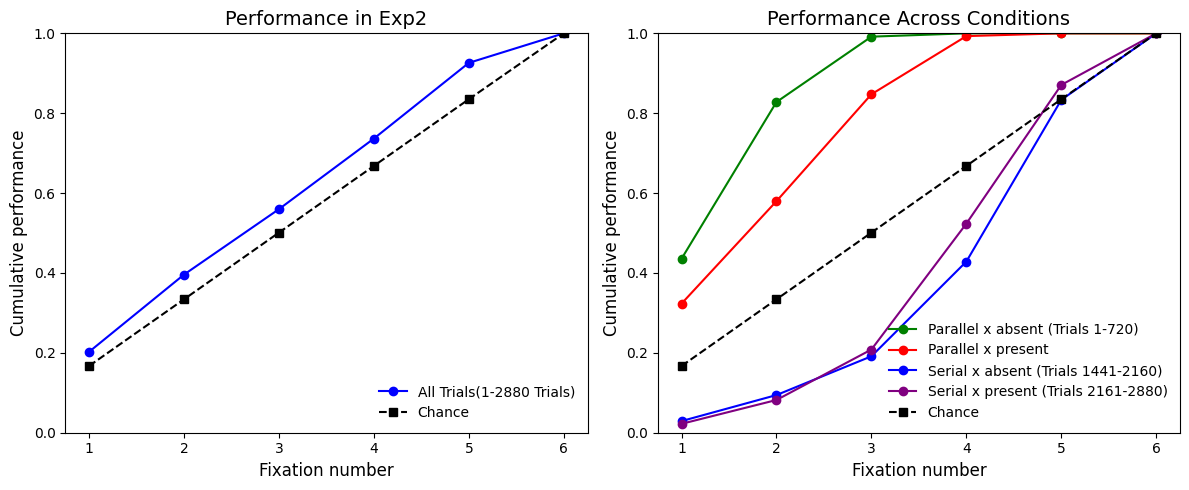

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Define fixation counts (1 to 6)
fixation_counts = range(1, 7)

# Function to calculate cumulative accuracy
def calculate_cumulative_accuracy(data, start_trial, end_trial):
    """
    Calculate cumulative accuracy for fixation counts 1 to 6.

    Parameters:
        data (pd.DataFrame): Input data containing 'fixations_count' and 'found'.
        start_trial (int): Start trial index (inclusive).
        end_trial (int): End trial index (inclusive).

    Returns:
        list: Cumulative accuracy for fixation counts 1 through 6.
    """
    filtered_data = data[(data['image_idx'] >= start_trial) & (data['image_idx'] <= end_trial)]
    cumulative_accuracy = []
    for count in fixation_counts:
        # Filter trials where fixation_count <= count
        filtered_count = filtered_data[filtered_data['fixations_count'] <= count]
        total_trials = len(filtered_data)

        # Calculate accuracy for trials found within this fixation range
        accuracy = len(filtered_count[filtered_count['found'] == True]) / total_trials if total_trials > 0 else 0
        cumulative_accuracy.append(accuracy)
    return cumulative_accuracy

# Load the dataset
file_path = "/content/drive/MyDrive/TL_Exp/SearchOutput/final_result.csv"
data = pd.read_csv(file_path)

# Calculate cumulative accuracy for different trial ranges
cumulative_accuracy_1_720 = calculate_cumulative_accuracy(data, 1, 721)
cumulative_accuracy_721_1440 = calculate_cumulative_accuracy(data, 721, 1441)
cumulative_accuracy_1441_2160 = calculate_cumulative_accuracy(data, 1441, 2161)
cumulative_accuracy_2161_2880 = calculate_cumulative_accuracy(data, 2161, 2881)
cumulative_accuracy_all = calculate_cumulative_accuracy(data, 1, 2881)

# Chance cumulative accuracy values
chance_cumulative_accuracy = [0.167, 0.334, 0.501, 0.668, 0.835, 1]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: All Trials vs Chance
axes[0].plot(
    fixation_counts, cumulative_accuracy_all,
    marker='o', color='blue', label="All Trials(1-2880 Trials)", linestyle='-'
)
axes[0].plot(
    fixation_counts, chance_cumulative_accuracy,
    marker='s', color='black', label="Chance", linestyle='--'
)
axes[0].set_xlabel("Fixation number", fontsize=12)
axes[0].set_ylabel("Cumulative performance", fontsize=12)
axes[0].set_title("Performance in Exp2", fontsize=14, loc='center')
axes[0].set_xticks(fixation_counts)
axes[0].set_ylim(0, 1)
axes[0].legend(fontsize=10, loc='lower right', frameon=False)

# Plot 2: Individual Trial Ranges vs Chance
axes[1].plot(
    fixation_counts, cumulative_accuracy_1_720,
    marker='o', color='green', label="Parallel x absent (Trials 1-720)", linestyle='-'
)
axes[1].plot(
    fixation_counts, cumulative_accuracy_721_1440,
    marker='o', color='red', label="Parallel x present", linestyle='-'
)
axes[1].plot(
    fixation_counts, cumulative_accuracy_1441_2160,
    marker='o', color='blue', label="Serial x absent (Trials 1441-2160)", linestyle='-'
)
axes[1].plot(
    fixation_counts, cumulative_accuracy_2161_2880,
    marker='o', color='purple', label="Serial x present (Trials 2161-2880)", linestyle='-'
)
axes[1].plot(
    fixation_counts, chance_cumulative_accuracy,
    marker='s', color='black', label="Chance", linestyle='--'
)

axes[1].set_xlabel("Fixation number", fontsize=12)
axes[1].set_ylabel("Cumulative performance", fontsize=12)
axes[1].set_title("Performance Across Conditions", fontsize=14, loc='center')
axes[1].set_xticks(fixation_counts)
axes[1].set_ylim(0, 1)
axes[1].legend(fontsize=10, loc='lower right', frameon=False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



sloc_fixation_index = 1 Ratio (low present + high present): 0.4168
sloc_fixation_index = 1 Ratio (low present): 0.4597
sloc_fixation_index = 1 Ratio (high present): 0.3750


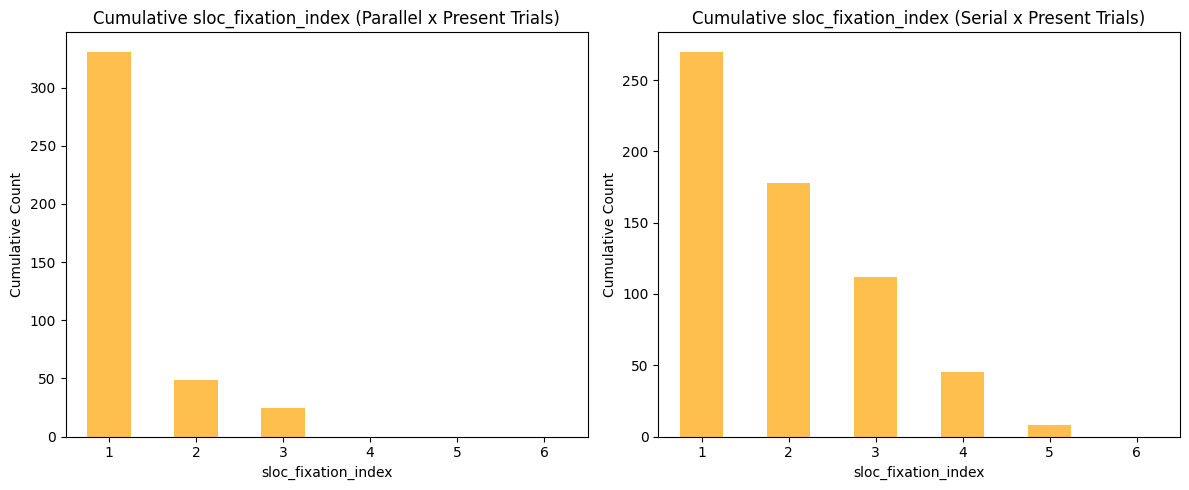

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드
file_path = "/content/drive/MyDrive/TL_Exp/SearchOutput/final_result.csv"
data = pd.read_csv(file_path)

# 조건 정의
low_present_idx = list(range(721, 1441))
high_present_idx = list(range(2161, 2881))

# 조건별 데이터 필터링
low_present = data[data['image_idx'].isin(low_present_idx)]
high_present = data[data['image_idx'].isin(high_present_idx)]
present = pd.concat([low_present, high_present])

# sloc_fixation_index 누적값 계산
sloc_trials = data[(data['image_idx'] >= 720) & (data['image_idx'] <= 1440) | (data['image_idx'] >= 2160) & (data['image_idx'] <= 2880)]
sloc_counts = sloc_trials['sloc_fixation_index'].value_counts().reindex(range(1, 7), fill_value=0)

sloc_trials1 = data[(data['image_idx'] >= 720) & (data['image_idx'] <= 1440)]
sloc_trials2 = data[(data['image_idx'] >= 2160) & (data['image_idx'] <= 2880)]
sloc_counts1 = sloc_trials1['sloc_fixation_index'].value_counts().reindex(range(1, 7), fill_value=0)
sloc_counts2 = sloc_trials2['sloc_fixation_index'].value_counts().reindex(range(1, 7), fill_value=0)


# sloc_fixation_index가 1인 비율 계산
sloc_index_1_ratio = len(sloc_trials[sloc_trials['sloc_fixation_index'] == 1]) / len(sloc_trials) if len(sloc_trials) > 0 else 0

# sloc_fixation_index가 1인 비율 (조건별)
low_present_sloc_1_ratio = len(low_present[low_present['sloc_fixation_index'] == 1]) / len(low_present) if len(low_present) > 0 else 0
high_present_sloc_1_ratio = len(high_present[high_present['sloc_fixation_index'] == 1]) / len(high_present) if len(high_present) > 0 else 0

# sloc_fixation_index = 1 비율 출력
print(f"\nsloc_fixation_index = 1 Ratio (low present + high present): {sloc_index_1_ratio:.4f}")
print(f"sloc_fixation_index = 1 Ratio (low present): {low_present_sloc_1_ratio:.4f}")
print(f"sloc_fixation_index = 1 Ratio (high present): {high_present_sloc_1_ratio:.4f}")

# 시각화: 두 그래프를 하나의 열에 배치
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 두 번째 그래프: sloc_fixation_index 누적값

sloc_counts1.plot(kind='bar', color='orange', alpha=0.7, ax=axs[0])
axs[0].set_xlabel("sloc_fixation_index")
axs[0].set_ylabel("Cumulative Count")
axs[0].set_title("Cumulative sloc_fixation_index (Parallel x Present Trials)")
axs[0].tick_params(axis='x', rotation=0)

sloc_counts2.plot(kind='bar', color='orange', alpha=0.7, ax=axs[1])
axs[1].set_xlabel("sloc_fixation_index")
axs[1].set_ylabel("Cumulative Count")
axs[1].set_title("Cumulative sloc_fixation_index (Serial x Present Trials)")
axs[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

